# Logistic Regression

- __Model info:__
    - features:
        - contains negative words (T/F)
        - contains offensive words (T/F)
        - sentiment (+, -, 0)
        - contains emoji
    - model: Logistic Regression
    - max acc: 80% counter with ngrams(1, 3)
    
https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import collections

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import matthews_corrcoef
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier


from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer

In [ ]:
#nltk.download(['stopwords'])

In [98]:
tweets_DF = pd.read_csv('../Dataset-OLID/OLIDv1.0/data_subtask_a.csv')
tweets_DF.head(10)

,Unnamed: 0,id,tweet,subtask_a,label_a
0,0,86426,@USER She should ask a few native Americans wh...,OFF,1
1,1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1
2,2,16820,Amazon is investigating Chinese employees who ...,NOT,0
3,3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,1
4,4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,0
5,5,97670,@USER Liberals are all Kookoo !!!,OFF,1
6,6,77444,@USER @USER Oh noes! Tough shit.,OFF,1
7,7,52415,@USER was literally just talking about this lo...,OFF,1
8,8,45157,@USER Buy more icecream!!!,NOT,0
9,9,13384,@USER Canada doesn’t need another CUCK! We alr...,OFF,1


In [99]:
tweets_test_DF = pd.read_csv('../Dataset-OLID/OLIDv1.0/test_data_subtask_a.csv')
tweets_test_DF.head(5)

,Unnamed: 0,id,tweet,subtask_a,label_a
0,0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OFF,1
1,1,27014,"#ConstitutionDay is revered by Conservatives, ...",NOT,0
2,2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,NOT,0
3,3,13876,#Watching #Boomer getting the news that she is...,NOT,0
4,4,60133,#NoPasaran: Unity demo to oppose the far-right...,OFF,1


In [241]:
tweets_test_DF = pd.read_csv('../Dataset-TSA/sentiment500.csv')
tweets_test_DF.head(5)

,id,sentiment,tweet
0,5688,POS,@Janet_Reid I need help getting my book to ma...
1,2270,POS,I had a snicker doodle for breakfast. #adulting
2,6452,POS,I slept good 2day I barely sleep any other day...
3,5692,NEG,I can’t believe hit folk singer Charles Manson...
4,6924,POS,@EA $60 triple A title with microtransactions ...


In [8]:
tweets_test_DF = pd.read_csv('../Dataset-MTSA/tweets_test.tsv', sep="\t")
tweets_test_DF["label"] = tweets_test_DF["sentiment"].apply(lambda x: 1 if x == "NEG" else 0)
tweets_test_DF.head(5)

,id,sentiment,tweet,label
0,5688,POS,@Janet_Reid I need help getting my book to ma...,0
1,2270,POS,I had a snicker doodle for breakfast. #adulting,0
2,6452,POS,I slept good 2day I barely sleep any other day...,0
3,5692,NEG,I can’t believe hit folk singer Charles Manson...,1
4,6924,POS,@EA $60 triple A title with microtransactions ...,0


In [12]:
tweets_test_DF = pd.read_csv("/home/dorotea/Documents/FER/APT/tmp/tweets_50-50.tsv", sep="\t")
tweets_test_DF["label"] = tweets_test_DF["sentiment"].apply(lambda x: 1 if x == "NEG" else 0)
tweets_test_DF.head(5)

,id,sentiment,tweet,label
0,1964,NEG,Tried to eat some chicken tacos after being ve...,1
1,2128,NEG,"Idk what’s messing up worse this COD WWII, U-v...",1
2,3332,NOT,I️ need to find me a singer and dancer so we c...,0
3,253,NOT,Now playing Our Turf Football: Goodell vs. Jon...,0
4,4466,NEG,I miss football :(,1


In [210]:
#tweets_test_DF.to_csv('../Dataset-TSA/sentiment500.csv', encoding='utf-8')

In [121]:
#tweets500 = tweets_test_DF[:500]
#tweets500.to_csv('../Dataset-TSA/sentiment500.csv', encoding='utf-8')


In [12]:
#preparing new data
'''
tweets_test_DF = tweets_test_DF.rename(columns={"SentimentText":"tweet", "Sentiment":"label_a", "ItemID":"id"})
tweets_test_DF["Unnamed: 0"] = tweets_test_DF.index
tweets_test_DF["label_a"] = tweets_test_DF["label_a"].apply(lambda x: int(not x))
tweets_test_DF = tweets_test_DF.drop(columns=["Unnamed: 0.1"], axis=1)
tweets_test_DF["subtask_a"] = tweets_test_DF["label_a"].apply(lambda x: True if x else False)
tweets_test_DF.to_csv('../Dataset-TSA/sentiment.csv', encoding='utf-8')
'''

'\ntweets_test_DF = tweets_test_DF.rename(columns={"SentimentText":"tweet", "Sentiment":"label_a", "ItemID":"id"})\ntweets_test_DF["Unnamed: 0"] = tweets_test_DF.index\ntweets_test_DF.to_csv(\'../Dataset-TSA/sentiment.csv\', encoding=\'utf-8\')\n'

## 1. Preprocessing

In [13]:
import nltk
from nltk import word_tokenize
from nltk import ngrams
from nltk.tokenize.casual import TweetTokenizer

'''
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import WordPunctTokenizer
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
'''


'\nfrom nltk.corpus import stopwords\nfrom nltk.stem import PorterStemmer\nfrom nltk.tokenize import WordPunctTokenizer\nfrom nltk.collocations import BigramCollocationFinder\nfrom nltk.metrics import BigramAssocMeasures\n'

In [100]:
# remove unnecessery columns
tweets_DF = tweets_DF.rename(columns = {'label_a':'label'})
tweets_DF = tweets_DF.drop(["Unnamed: 0", "id", "subtask_a"], axis=1)

tweets_test_DF = tweets_test_DF.rename(columns = {'label_a':'label'})
tweets_test_DF = tweets_test_DF.drop(["Unnamed: 0", "id", "subtask_a"], axis=1)


-----------------

Removing @USER

In [15]:
import re

In [16]:
REMOVE_USER = re.compile("@USER")

def remove_user(tweet):
    return REMOVE_USER.sub("", tweet)

In [101]:
tweets_DF['tweet'] = tweets_DF['tweet'].apply(remove_user)
tweets_test_DF['tweet'] = tweets_test_DF['tweet'].apply(remove_user)

-------------------------------
Extracting emoji

In [18]:
import emoji
import regex

In [19]:
def split_count(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

In [102]:
tweets_DF['emoji'] = tweets_DF['tweet'].apply(split_count)
tweets_test_DF['emoji'] = tweets_test_DF['tweet'].apply(split_count)

----------------------

### B) Sentiment

In [21]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [22]:
analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return [score['neg'], score['neu'], score['pos'], score['compound']]

In [103]:
tweets_DF['sentiment'] = tweets_DF['tweet'].apply(sentiment_analyzer_scores)
tweets_DF['negative_sentiment'] = tweets_DF['sentiment'].apply(lambda row: row[0])
tweets_DF['neutral_sentiment'] = tweets_DF['sentiment'].apply(lambda row: row[1])
tweets_DF['positive_sentiment'] = tweets_DF['sentiment'].apply(lambda row: row[2])
tweets_DF['compound'] = tweets_DF['sentiment'].apply(lambda row: row[3])

tweets_DF = tweets_DF.drop(["sentiment"], axis=1)

In [104]:
tweets_test_DF['sentiment'] = tweets_test_DF['tweet'].apply(sentiment_analyzer_scores)
tweets_test_DF['negative_sentiment'] = tweets_test_DF['sentiment'].apply(lambda row: row[0])
tweets_test_DF['neutral_sentiment'] = tweets_test_DF['sentiment'].apply(lambda row: row[1])
tweets_test_DF['positive_sentiment'] = tweets_test_DF['sentiment'].apply(lambda row: row[2])
tweets_test_DF['compound'] = tweets_test_DF['sentiment'].apply(lambda row: row[3])

tweets_test_DF = tweets_test_DF.drop(["sentiment"], axis=1)

-------------------------------
### C) Positive, negative and offensive words

In [25]:
from nltk import word_tokenize

In [26]:
negative_words_file = open("negative-words.txt")
negative_words = []

positive_words_file = open("positive-words.txt")
positive_words = []

for line in negative_words_file:
    if not str.startswith(line, ";"):
        negative_words.append(line.split("\n")[0])
        
negative_words = negative_words[1:]

for line in positive_words_file:
    if not str.startswith(line, ";"):
        positive_words.append(line.split("\n")[0])
        
positive_words = positive_words[1:]

In [38]:
def check_for_negative_words(tweet):
    tweet = preprocess_tweet(tweet)
    tweet = str.lower(tweet)
    words = word_tokenize(tweet)
    if any(word in negative_words for word in words):
        return True
    return False

def check_for_positive_words(tweet):
    tweet = preprocess_tweet(tweet)
    tweet = str.lower(tweet)
    words = word_tokenize(tweet)
    if any(word in positive_words for word in words):
        return True
    return False

In [105]:
tweets_DF['negative_words'] = tweets_DF['tweet'].apply(check_for_negative_words)
tweets_test_DF['negative_words'] = tweets_test_DF['tweet'].apply(check_for_negative_words)

tweets_DF['positive_words'] = tweets_DF['tweet'].apply(check_for_positive_words)
tweets_test_DF['positive_words'] = tweets_test_DF['tweet'].apply(check_for_positive_words)

In [40]:
offensive_words_file = open("facebook_bad_words.txt")
offensive_words = []

for line in offensive_words_file:
    offensive_words.append(line.strip())
        
offensive_words[0] in "baldjd 2g1c" 

True

In [32]:
def check_for_offensive_words(tweet):
    #tweet = preprocess_tweet(tweet)
    tweet = str.lower(tweet)
    if any(word in tweet for word in offensive_words):
        return True
    return False

In [106]:
tweets_DF['offensive_words'] = tweets_DF['tweet'].apply(check_for_offensive_words)
tweets_test_DF['offensive_words'] = tweets_test_DF['tweet'].apply(check_for_offensive_words)

----------------------------
### D) Removing stopwords, lemmatization

In [34]:
english_stop_words = stopwords.words('english')

In [37]:
lemmatizer = WordNetLemmatizer() #SnowballStemmer('english')
   
def preprocess_tweet(tweet, remove_stopwords=False):
    #remove all non letters
    regex = re.compile('[^a-zA-Z]')
    removed_nonalphanumeric = regex.sub(' ', tweet)
    lowercased_tweet = str.lower(removed_nonalphanumeric)

    #remove stopwords
    if remove_stopwords:
        lowercased_tweet = " ".join(word if word not in english_stop_words else "" for word in lowercased_tweet.split())
    
    #lemmatization
    lemmatized = ' '.join([lemmatizer.lemmatize(word) for word in lowercased_tweet.split()])
    return lemmatized
    

In [36]:
tweet = tweets_DF['tweet'][2]
print(tweet, "\n")
print(preprocess_tweet(tweet, False))
preprocess_tweet(tweet, True)

Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT 

amazon is investigating chinese employee who are selling internal data to third party seller looking for an edge in the competitive marketplace url amazon maga kag china tcot


'amazon investigating chinese employee selling internal data third party seller looking edge competitive marketplace url amazon maga kag china tcot'

In [107]:
tweets_DF['clean_tweet_with_stopwords'] = tweets_DF['tweet'].apply(preprocess_tweet, False)
tweets_DF['clean_tweet_without_stopwords'] = tweets_DF['tweet'].apply(preprocess_tweet, True)

tweets_test_DF['clean_tweet_with_stopwords'] = tweets_test_DF['tweet'].apply(preprocess_tweet, False)
tweets_test_DF['clean_tweet_without_stopwords'] = tweets_test_DF['tweet'].apply(preprocess_tweet, True)

### E) Word embeddings

In [43]:
from gensim.models import KeyedVectors, word2vec
from gensim.test.utils import common_texts, get_tmpfile

In [108]:
corpus = tweets_DF['clean_tweet_with_stopwords'].values

# we need to pass splitted sentences to the model
tokenized_sentences = [sentence.split() for sentence in corpus]
model = word2vec.Word2Vec(tokenized_sentences, min_count=1)
#model.save("word2vec.model")

In [45]:
model = word2vec.Word2Vec.load("word2vec.model")
#model.train(corpus, total_examples=1000, epochs=10)
#model.save("word2vec.model")

In [ ]:
model.vocabulary

In [46]:
def embedd(sentance):
    tokens = sentance.split()
    summed_embedding = np.zeros(100)
    for token in tokens:
        if token in model.wv:
            summed_embedding += model.wv[token]
        
        
    return summed_embedding/len(tokens)

In [47]:
tknz = TweetTokenizer()
tweets_test_DF['clean_tweet_with_stopwords'] = tweets_test_DF['tweet'].apply(preprocess_tweet)#(tknz.tokenize).apply(" ".join)

In [48]:
tweets_DF['embedding'] = tweets_DF['clean_tweet_with_stopwords'].apply(embedd)
tweets_test_DF['embedding'] = tweets_test_DF['clean_tweet_with_stopwords'].apply(embedd)

## 2. Models
------------------------------------

### 2.1 Model: sentiment

In [109]:
#creating train, test 
sentiment = tweets_DF[["negative_sentiment", "negative_words", "offensive_words"]].values
y = tweets_DF['label'].values

X_test_sentiment = tweets_test_DF[["negative_sentiment", "negative_words", "offensive_words"]].values
y_test_sentiment = tweets_test_DF['label'].values

X_train_sentiment, X_val_sentiment, y_train_sentiment, y_val_sentiment = train_test_split(sentiment, y, test_size=0.2, random_state=1000)

In [110]:
classifier_sentiment = LogisticRegression(max_iter=1000, multi_class='multinomial')
classifier_sentiment.fit(X_train_sentiment, y_train_sentiment)
score = classifier_sentiment.score(X_test_sentiment, y_test_sentiment)

print("Accuracy:", score)

Accuracy: 0.7802325581395348


In [111]:
y_pred = classifier_sentiment.predict(X_test_sentiment)
f1_score(y_test_sentiment, y_pred)

0.47645429362880887

### 2.2 Model : tf_idf

In [112]:
tweets = tweets_DF['tweet'].values
y = tweets_DF['label'].values

tweets_test = tweets_test_DF['tweet'].values
y_test = tweets_test_DF['label'].values

vectorizer_tf = TfidfVectorizer()
vectorizer_tf.fit(tweets)

tweets_train, tweets_valid, y_train, y_valid = train_test_split(tweets, y, test_size=0.2, random_state=1000)

X_train_tfidf = vectorizer_tf.transform(tweets_train)
X_valid_tfidf = vectorizer_tf.transform(tweets_valid)
X_test_tfidf  = vectorizer_tf.transform(tweets_test)

In [113]:
classifier_tfidf = LogisticRegression(max_iter=100)
classifier_tfidf.fit(X_train_tfidf, y_train)
score = classifier_tfidf.score(X_test_tfidf, y_test)

print("Accuracy:", score)

Accuracy: 0.7906976744186046


In [115]:
y_pred = classifier_tfidf.predict(X_test_tfidf)
f1_score(y_test, y_pred)

0.44099378881987583

### 2.3 Model: count_vector, clean data: char-based and word-based
- Old data voc size: 19083
- New data voc size: 16622

In [116]:
tweets = tweets_DF['clean_tweet_without_stopwords'].values
y = tweets_DF['label'].values

tweets_test = tweets_test_DF['clean_tweet_without_stopwords'].values
y_test = tweets_test_DF['label'].values

char_vectorizer = CountVectorizer(binary=True, analyzer='char' , ngram_range=(3, 5))
char_vectorizer.fit(tweets)

tweets_train, tweets_valid, y_train, y_valid = train_test_split(tweets, y, test_size=0.2, random_state=1000)

X_train_clean = char_vectorizer.transform(tweets_train)
X_valid_clean = char_vectorizer.transform(tweets_valid)
X_test_clean  = char_vectorizer.transform(tweets_test)

In [117]:
classifier_char = LogisticRegression(max_iter=1000)
classifier_char.fit(X_train_clean, y_train)
score = classifier_char.score(X_test_clean, y_test)

print("Accuracy:", score)

Accuracy: 0.7662790697674419


In [118]:
y_pred = classifier_char.predict(X_test_clean)
f1_score(y_test, y_pred)

0.5400457665903889

------------------------------

In [119]:
tweets = tweets_DF['clean_tweet_without_stopwords'].values
y = tweets_DF['label'].values

tweets_test = tweets_test_DF['clean_tweet_without_stopwords'].values
y_test = tweets_test_DF['label'].values

vectorizer = CountVectorizer(binary=True,  ngram_range=(1, 3))
vectorizer.fit(tweets)

tweets_train, tweets_valid, y_train, y_valid = train_test_split(tweets, y, test_size=0.2, random_state=1000)

X_train_clean = vectorizer.transform(tweets_train)
X_valid_clean = vectorizer.transform(tweets_valid)
X_test_clean  = vectorizer.transform(tweets_test)

In [120]:
classifier_clean = LogisticRegression(max_iter=1000)
classifier_clean.fit(X_train_clean, y_train)
score = classifier_clean.score(X_test_clean, y_test)

print("Accuracy:", score)

Accuracy: 0.8


In [121]:
y_pred = classifier_clean.predict(X_test_clean)
f1_score(y_test, y_pred)

0.5300546448087432

----------------------------

In [160]:
X_train_clean = vectorizer.transform(tweets[:9000])
X_test_clean  = vectorizer.transform(tweets[9000:])
y_train = y[:9000]
y_test = y[9000:]

classifier_clean = LogisticRegression(max_iter=1000)
classifier_clean.fit(X_train_clean, y_train)
score = classifier_clean.score(X_test_clean, y_test)

print("Accuracy:", score)

Accuracy: 0.7599056603773585


Failed to predicit:

In [ ]:
prediction = classifier_clean.predict(X_test_clean)
z = zip(prediction, y_test, range(9000, 9000+len(prediction)))
indices = np.array([i if p1!=p2 else -1 for p1, p2, i in z ])
indices = indices[indices>0]
for i in indices:
    print(tweets_DF['label'][i],tweets_DF['tweet'][i], tweets_DF['negative_words'][i],  "\n")

### 2.4 Word embeddings

In [161]:
tweets = tweets_DF['embedding'].values
tweets = np.array([np.array(t) for t in tweets]).reshape(-1, 100)
y = tweets_DF['label'].values

tweets_test = tweets_test_DF['embedding'].values
X_test_embedding = np.array([np.array(t) for t in tweets_test]).reshape(-1, 100)
y_test = tweets_test_DF['label'].values

X_train_embedding, X_val_embedding, y_train, y_val = train_test_split(tweets, y, test_size=0.25, random_state=1000)

In [162]:
classifier_embedding = LogisticRegression(max_iter=1000)
classifier_embedding.fit(X_train_embedding, y_train)
score = classifier_embedding.score(X_test_embedding, y_test)

print("Accuracy:", score)

Accuracy: 0.326


In [163]:
y_pred = classifier_embedding.predict(X_test_embedding)
f1_score(y_test, y_pred)

0.0

In [122]:
def ansamble(sentence):
    
    sentence = remove_user(sentence)
    neg, neu, pos, comp =  sentiment_analyzer_scores(sentence)
    negative_words = check_for_negative_words(sentence)
    offensive_words = check_for_offensive_words(sentence)
    
    preproc_with_stopwords = preprocess_tweet(sentence)
    preproc_no_stopwords = preprocess_tweet(sentence, True)
    
    #emb1 = embedd(preproc_with_stopwords)
    #emb2 = embedd(preproc_no_stopwords)
    
    score1 = classifier_sentiment.predict([[neg, negative_words, offensive_words]])
    
    tfidf = vectorizer_tf.transform([sentence])
    score2 = classifier_tfidf.predict(tfidf)
    
    count = vectorizer.transform([preproc_no_stopwords])
    score3 = classifier_clean.predict(count)
    
    count = char_vectorizer.transform([preproc_no_stopwords])
    score4 = classifier_char.predict(count)
    
    #score5 = classifier_embedding.predict([emb1])
    
    if not any(w in model.wv for w in preproc_no_stopwords.split()):# and score4[0]:
            return score4[0]
    
    vote = collections.Counter([score1[0], score2[0], score3[0], score4[0], score3[0]])
    if vote[0] > 3:
        return 0
    else:
        return 1

In [123]:
test_tweets = tweets_test_DF['tweet'].values
y = tweets_test_DF['label'].values

y_pred = [ansamble(t) for t in test_tweets]

print(accuracy_score(y, y_pred))
print(precision_score(y, y_pred))
print(recall_score(y, y_pred))
print(f1_score(y, y_pred))

0.827906976744186
0.8484848484848485
0.4666666666666667
0.6021505376344086


## 3.Test sentance

In [ ]:
def test(sentence):
    label = ["NOT", "OFF"]
    
    sentence = remove_user(sentence)
    neg, neu, pos, comp =  sentiment_analyzer_scores(sentence)
    negative_words = check_for_negative_words(sentence)
    offensive_words = check_for_offensive_words(sentence)
    
    preproc_with_stopwords = preprocess_tweet(sentence)
    preproc_no_stopwords = preprocess_tweet(sentence, True)
    
    emb1 = embedd(preproc_with_stopwords)
    emb2 = embedd(preproc_no_stopwords)
    
    score1 = classifier_sentiment.predict([[neg, negative_words, offensive_words]])
    print("Features:    Classified as:", label[score1[0]])
    
    tfidf = vectorizer_tf.transform([sentence])
    score2 = classifier_tfidf.predict(tfidf)
    print("TF_idf:      Classified as:", label[score2[0]])
    
    count = vectorizer.transform([preproc_no_stopwords])
    score3 = classifier_clean.predict(count)
    print("Ngrams:      Classified as:", label[score3[0]])
    
    count = char_vectorizer.transform([preproc_no_stopwords])
    score4 = classifier_char.predict(count)
    print("Char-ngrams: Classified as:", label[score4[0]])
    
    score5 = classifier_embedding.predict([emb1])
    print("Embeddings:  Classified as:", label[score5[0]])
    
    score6 = ansamble(sentence)
    print("Ansamble:    Classified as:", label[score6])
    

In [ ]:
test("Are you fuckisiiifn in?")
a = "Are you fuckisiiifn in?"
any([w in model.wv for w in a.split()])

---------------------------------
## 4. Testing correlation
__Tested correlation of some features and labels__

In [ ]:
y_pred = tweets_DF['label'].values
y_negative_words = tweets_DF['negative_words'].values
y_offensive_words = tweets_DF['offensive_words'].values
y_negative_sentiment = tweets_DF['negative_sentiment'].values
y_negative_sentiment = [1 if neg > 0  else 0 for neg in y_negative_sentiment]

print("Tweet contains negative word: ", matthews_corrcoef(y_pred, y_negative_words))
print("Tweet has some negative sentiment: ", matthews_corrcoef(y_pred, y_negative_sentiment))
print("Tweet contains offensive words: ", matthews_corrcoef(y_pred, y_offensive_words))

## 5. Drawing

In [63]:
import matplotlib.pyplot as plt

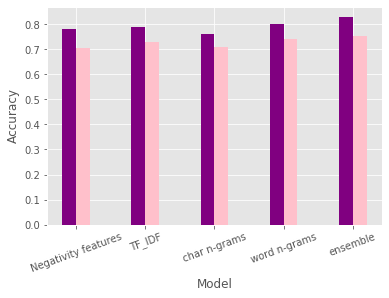

In [128]:

x = [
    "Negativity features",
    "TF_IDF",
    "char n-grams",
    "word n-grams",
    "ensemble"
]
#x = date2num(x)

olid = [0.78, 0.79, 0.76, 0.8, 0.828]
mts = [0.705, 0.73, 0.708, 0.743, 0.752]

x_pos = np.arange(len(x))
ax = plt.subplot(111)
ax.bar(x_pos-0.1, olid, width=0.2, color='purple', align='center')
ax.bar(x_pos+0.1, mts, width=0.2, color='pink', align='center')
#ax.bar(x_pos+0.2, k, width=0.2, color='r', align='center')
plt.xticks(x_pos, x, rotation=20)
plt.ylabel("Accuracy")
plt.xlabel("Model")



plt.show()

## TODO
https://docs.google.com/document/d/1OdniS8GEYwaFJy_zNC5GpXkceuGxmOtPK_dV9QAecho/edit

----------------------------

---------------------